<a href="https://colab.research.google.com/github/SophieShin/Python/blob/main/Short_Long_Term_IR__VAR%2CGrangerCausality%2CImpulseResponse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR


In [ ]:
df = pd.read_csv("/content/InterestRate.csv")


In [ ]:
df

,Date,3y,10y
0,20140303,2.892,3.561
1,20140304,2.917,3.581
2,20140305,2.906,3.569
3,20140306,2.901,3.572
4,20140307,2.907,3.587
...,...,...,...
2658,20241223,2.615,2.843
2659,20241224,2.623,2.874
2660,20241226,2.645,2.903
2661,20241227,2.641,2.860


In [ ]:
df['log_3y'] = np.log(df['3y'])
df['log_10y'] = np.log(df['10y'])

In [ ]:
df['dlog_3y'] = df['log_3y'].diff()
df['dlog_10y'] = df['log_10y'].diff()

In [ ]:
var_data = df.dropna()

In [ ]:
var_data=df[['dlog_3y', 'dlog_10y']].dropna()

In [ ]:
model = VAR(var_data)

# 최대 10시차까지 비교해보고 정보기준 확인
lag_order_results = model.select_order(maxlags=10)
print(lag_order_results.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.45     -17.44*   2.644e-08     -17.45*
1       -17.45      -17.44   2.643e-08      -17.44
2       -17.45      -17.43   2.635e-08      -17.44
3       -17.46      -17.43   2.623e-08      -17.45
4       -17.46      -17.42   2.613e-08      -17.45
5       -17.46      -17.41   2.618e-08      -17.44
6       -17.47      -17.41   2.595e-08      -17.45
7       -17.47      -17.40   2.599e-08      -17.44
8       -17.46      -17.39   2.601e-08      -17.44
9      -17.47*      -17.39  2.589e-08*      -17.44
10      -17.47      -17.38   2.589e-08      -17.44
--------------------------------------------------


In [ ]:
lag_order = 9

In [ ]:
var_res = model.fit(lag_order)

In [ ]:
print(var_res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Nov, 2025
Time:                     08:11:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -17.3858
Nobs:                     2653.00    HQIC:                  -17.4395
Log likelihood:           15683.1    FPE:                2.58736e-08
AIC:                     -17.4700    Det(Omega_mle):     2.55070e-08
--------------------------------------------------------------------
Results for equation dlog_3y
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.000016         0.000327           -0.048           0.962
L1.dlog_3y         -0.047228         0.034310           -1.377           0.169
L1.dlog_10y         0.036879         0.034622            1.065    

In [ ]:
# 마지막 관측값 기준으로 향후 h-step 예측
h = 10  # 10기간 예측
forecast = var_res.forecast(y=var_data.values[-lag_order:], steps=h)

# 예측 결과를 DataFrame으로 정리
forecast_index = pd.date_range(start=var_data.index[-1], periods=h+1, freq='D')[1:]
# Select only the dlog_Fx and dlog_TradingVolume forecasts (assuming they are the last two columns)
# If the order changes, these indices might need adjustment
forecast_df = pd.DataFrame(forecast[:, [0, 1]], # Slicing forecast to get only the relevant columns
                           index=forecast_index,
                           columns=['dlog_fx_hat', 'dlog_vol_hat'])

print(forecast_df.head())

                               dlog_fx_hat  dlog_vol_hat
1970-01-02 00:00:00.000002662     0.006266      0.003525
1970-01-03 00:00:00.000002662    -0.004735     -0.003293
1970-01-04 00:00:00.000002662     0.004811      0.003822
1970-01-05 00:00:00.000002662     0.000392      0.000547
1970-01-06 00:00:00.000002662    -0.002073     -0.001926


In [ ]:
var_res.resid.head()


,dlog_3y,dlog_10y
10,0.005268,0.010351
11,-0.002316,0.006515
12,-0.003128,-0.002662
13,0.015387,0.006232
14,0.007889,0.007670


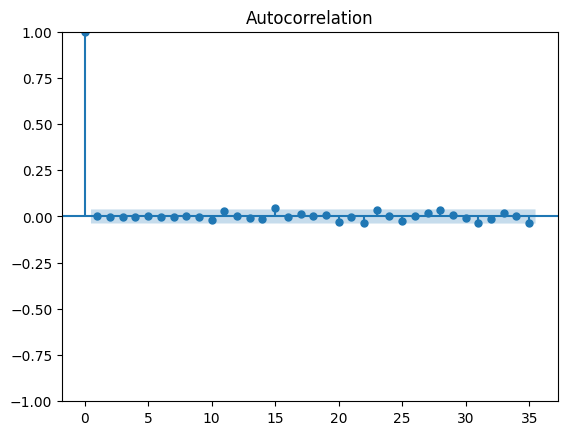

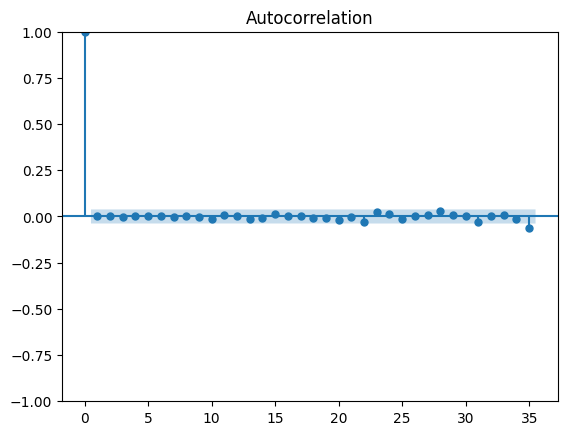

In [ ]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(var_res.resid['dlog_3y'])

sm.graphics.tsa.plot_acf(var_res.resid['dlog_10y'])
plt.show()

In [ ]:
var_res.is_stable(verbose=True)


Eigenvalues of VAR(1) rep
0.7877097304809044
0.6586290667908371
0.7465254629061728
0.7465254629061728
0.713899976861232
0.713899976861232
0.7868935625258363
0.7868935625258363
0.709982129425683
0.709982129425683
0.7685533480557788
0.7685533480557788
0.6847754011275377
0.6847754011275377
0.7730942232931461
0.7730942232931461
0.6249581121255071
0.6249581121255071


np.True_

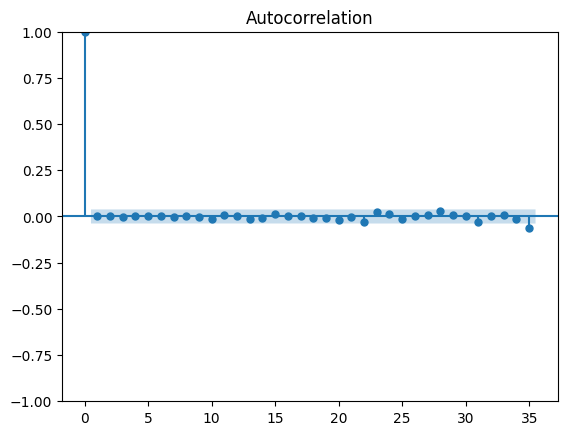

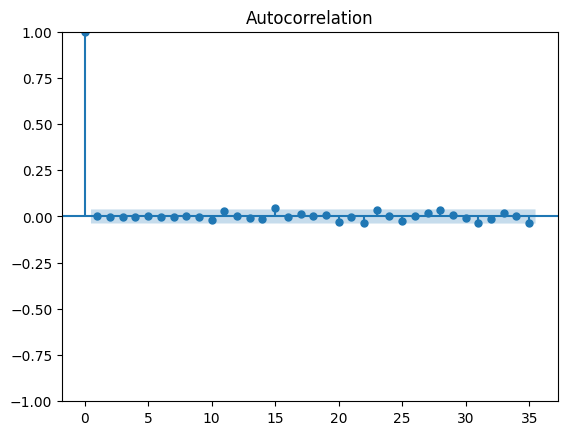

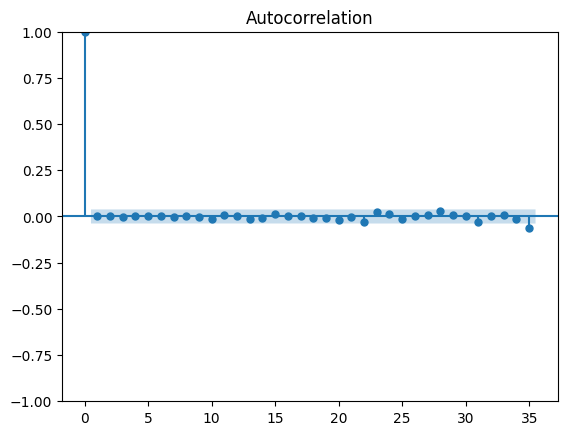

In [ ]:
sm.graphics.tsa.plot_acf(var_res.resid['dlog_3y'])
sm.graphics.tsa.plot_acf(var_res.resid['dlog_10y'])

In [ ]:
var_res.test_causality('dlog_3y', ['dlog_10y'], kind='f').summary()


Test statistic,Critical value,p-value,df
4.464,1.882,0.000,"(9, 5268)"


In [ ]:
var_res.test_causality('dlog_10y', ['dlog_3y'], kind='f').summary()

Test statistic,Critical value,p-value,df
1.472,1.882,0.152,"(9, 5268)"


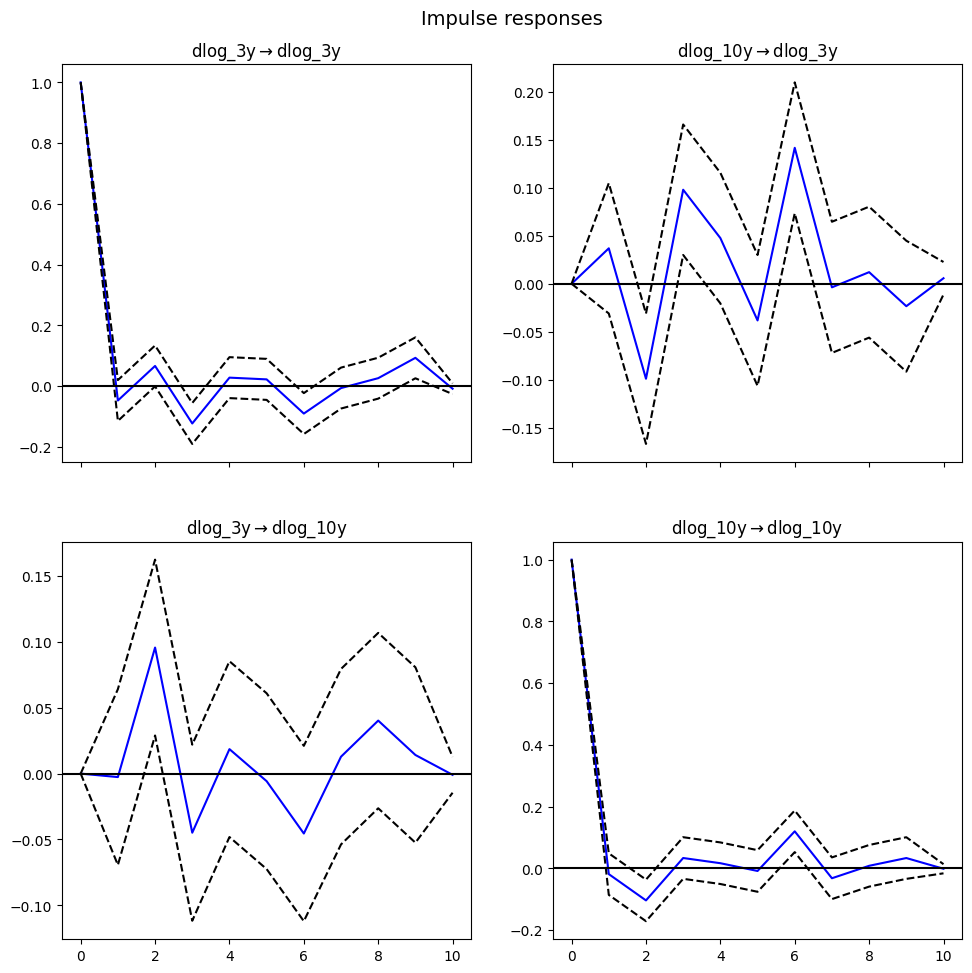

In [ ]:
# 1) IRF 객체 생성 (10 스텝)
irf = var_res.irf(10)

# 2) 기본 플롯
irf.plot(orth=False)   # orth=True로 하면 직교화(Cholesky) 충격
plt.show()

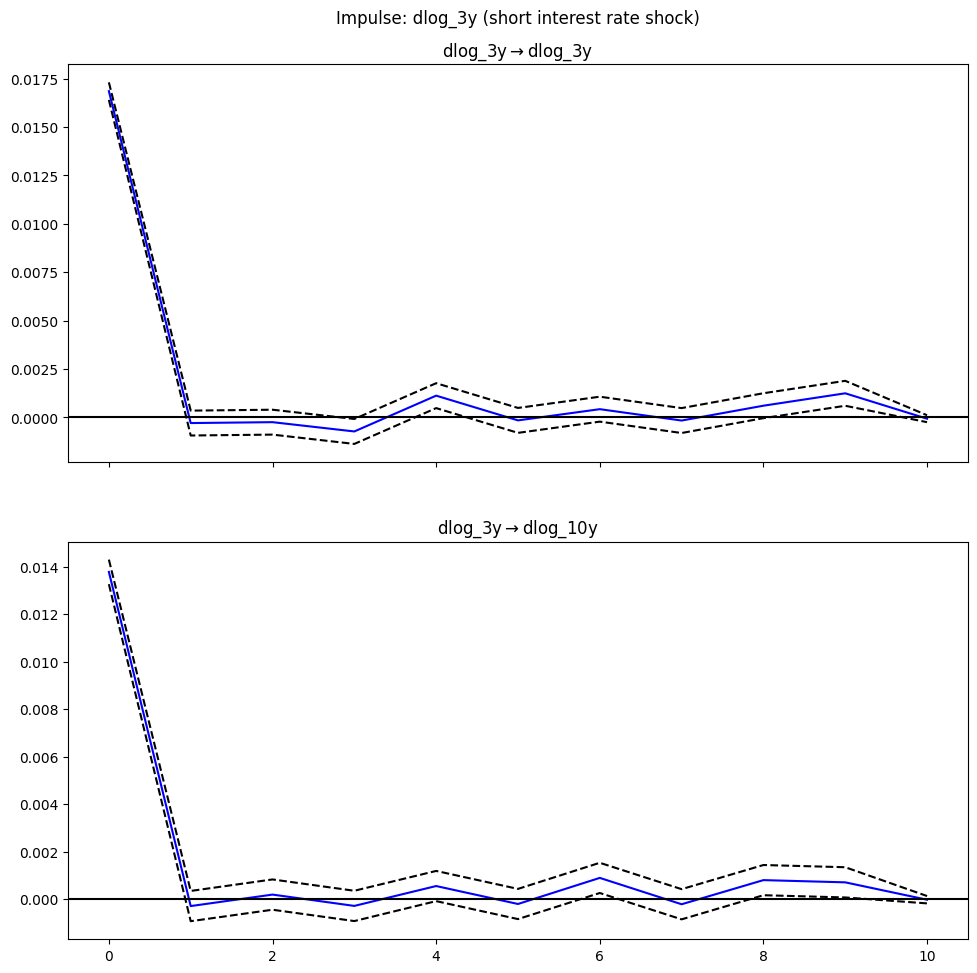

In [ ]:
irf.plot(impulse='dlog_3y', orth=True)
plt.suptitle("Impulse: dlog_3y (short interest rate shock)")
plt.show()

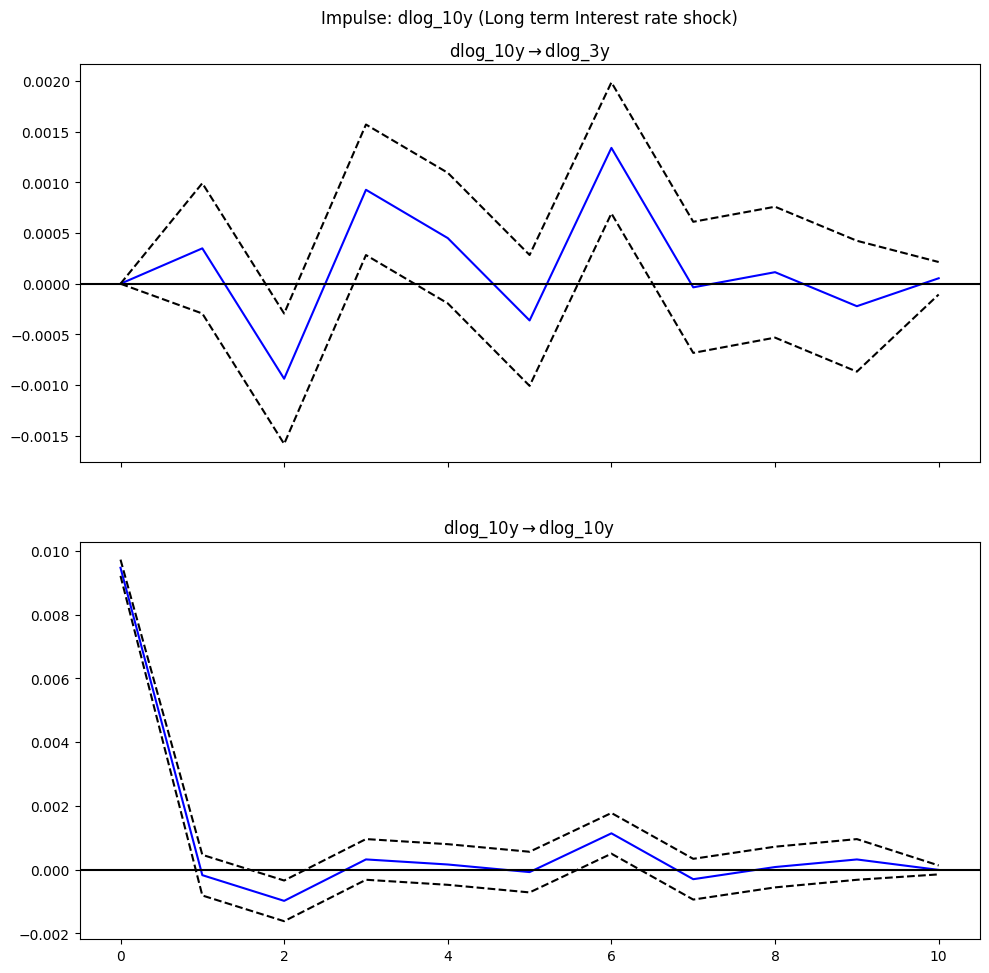

In [ ]:
irf.plot(impulse='dlog_10y', orth=True)
plt.suptitle("Impulse: dlog_10y (Long term Interest rate shock)")
plt.show()